In [22]:
import xarray as xr
import xclim as xc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

In [57]:
z500_files = [
    '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/zg500/zg500_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_202202-202202.nc',
    '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/zg500/zg500_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_202203-202203.nc'
]

pr_files = [
    '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_202202-202202.nc',
    '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_202203-202203.nc'
    
]

psl_files = [
    '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/psl/psl_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_202202-202202.nc',
    '/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/psl/psl_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_202203-202203.nc'
    
]

In [72]:
z500_ds = xr.open_mfdataset(z500_files)
pr_ds = xr.open_mfdataset(pr_files)
psl_ds = xr.open_mfdataset(psl_files)

z500_da = z500_ds.sel({'time': slice('2022-02-23', '2022-03-09')})['zg500']
pr_da = pr_ds.sel({'time': slice('2022-02-23', '2022-03-09')})['pr']
pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
psl_da = psl_ds.sel({'time': slice('2022-02-23', '2022-03-09')})['psl']
psl_da = xc.units.convert_units_to(psl_da, 'hPa')

z500_da_mean = z500_da.mean('time', keep_attrs=True)
pr_da_sum = pr_da.sum('time', keep_attrs=True)
psl_da_mean = psl_da.mean('time', keep_attrs=True)

In [73]:
def plot_average(contour_da, contour_var):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)

    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)

    pr_da_sum.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmocean.cm.rain,
        levels=[0, 100, 200, 300, 400, 500, 600, 700, 800],
        extend='max',
        cbar_kwargs={'label': 'total precipitation (mm)'},
    )
    
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    ax1.coastlines()
    #ax.set_extent([-140, -60, 20, 70])
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), 23 Feb - 9 Mar, 2022')
    plt.savefig(
        f'{contour_var}_mean_BARRA2_2022-02-23_2022-03-09.png',
        bbox_inches='tight',
        facecolor='white',
        dpi=300
    )

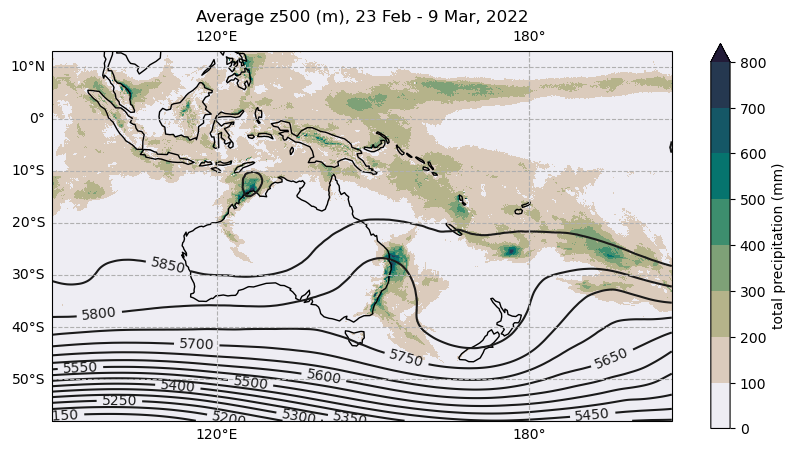

In [74]:
plot_average(z500_da_mean, 'z500')

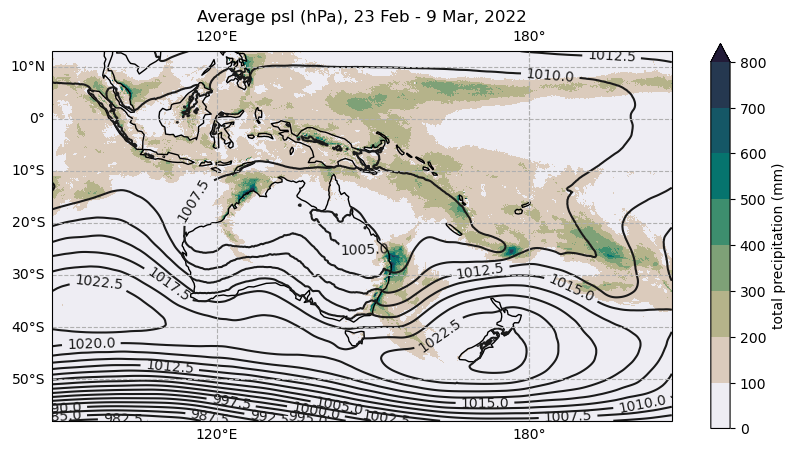

In [75]:
plot_average(psl_da_mean, 'psl')

In [84]:
def plot_days(contour_da, contour_var):
    """Plot days"""

    fig = plt.figure(figsize=[20, 18])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 75)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 5)

    for day in range(15):
        ax = fig.add_subplot(5, 3, day + 1, projection=map_proj)
        pr_da.isel({'time': day}).plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.rain,
            levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            extend='max',
            cbar_kwargs={'label': 'total precipitation (mm)'},
        )
    
        lines = contour_da.isel({'time': day}).plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
        ax.coastlines()
        ax.gridlines(linestyle='--', draw_labels=True)
        date = str(pr_da.isel({'time': day})['time'].dt.strftime('%d %b').values)
        ax.set_title(date)
    plt.suptitle(f'Daily {contour_var} ({contour_da.units})')
    plt.savefig(
        f'{contour_var}_days_BARRA2_2022-02-23_2022-03-09.png',
        bbox_inches='tight',
        facecolor='white',
        dpi=300
    )

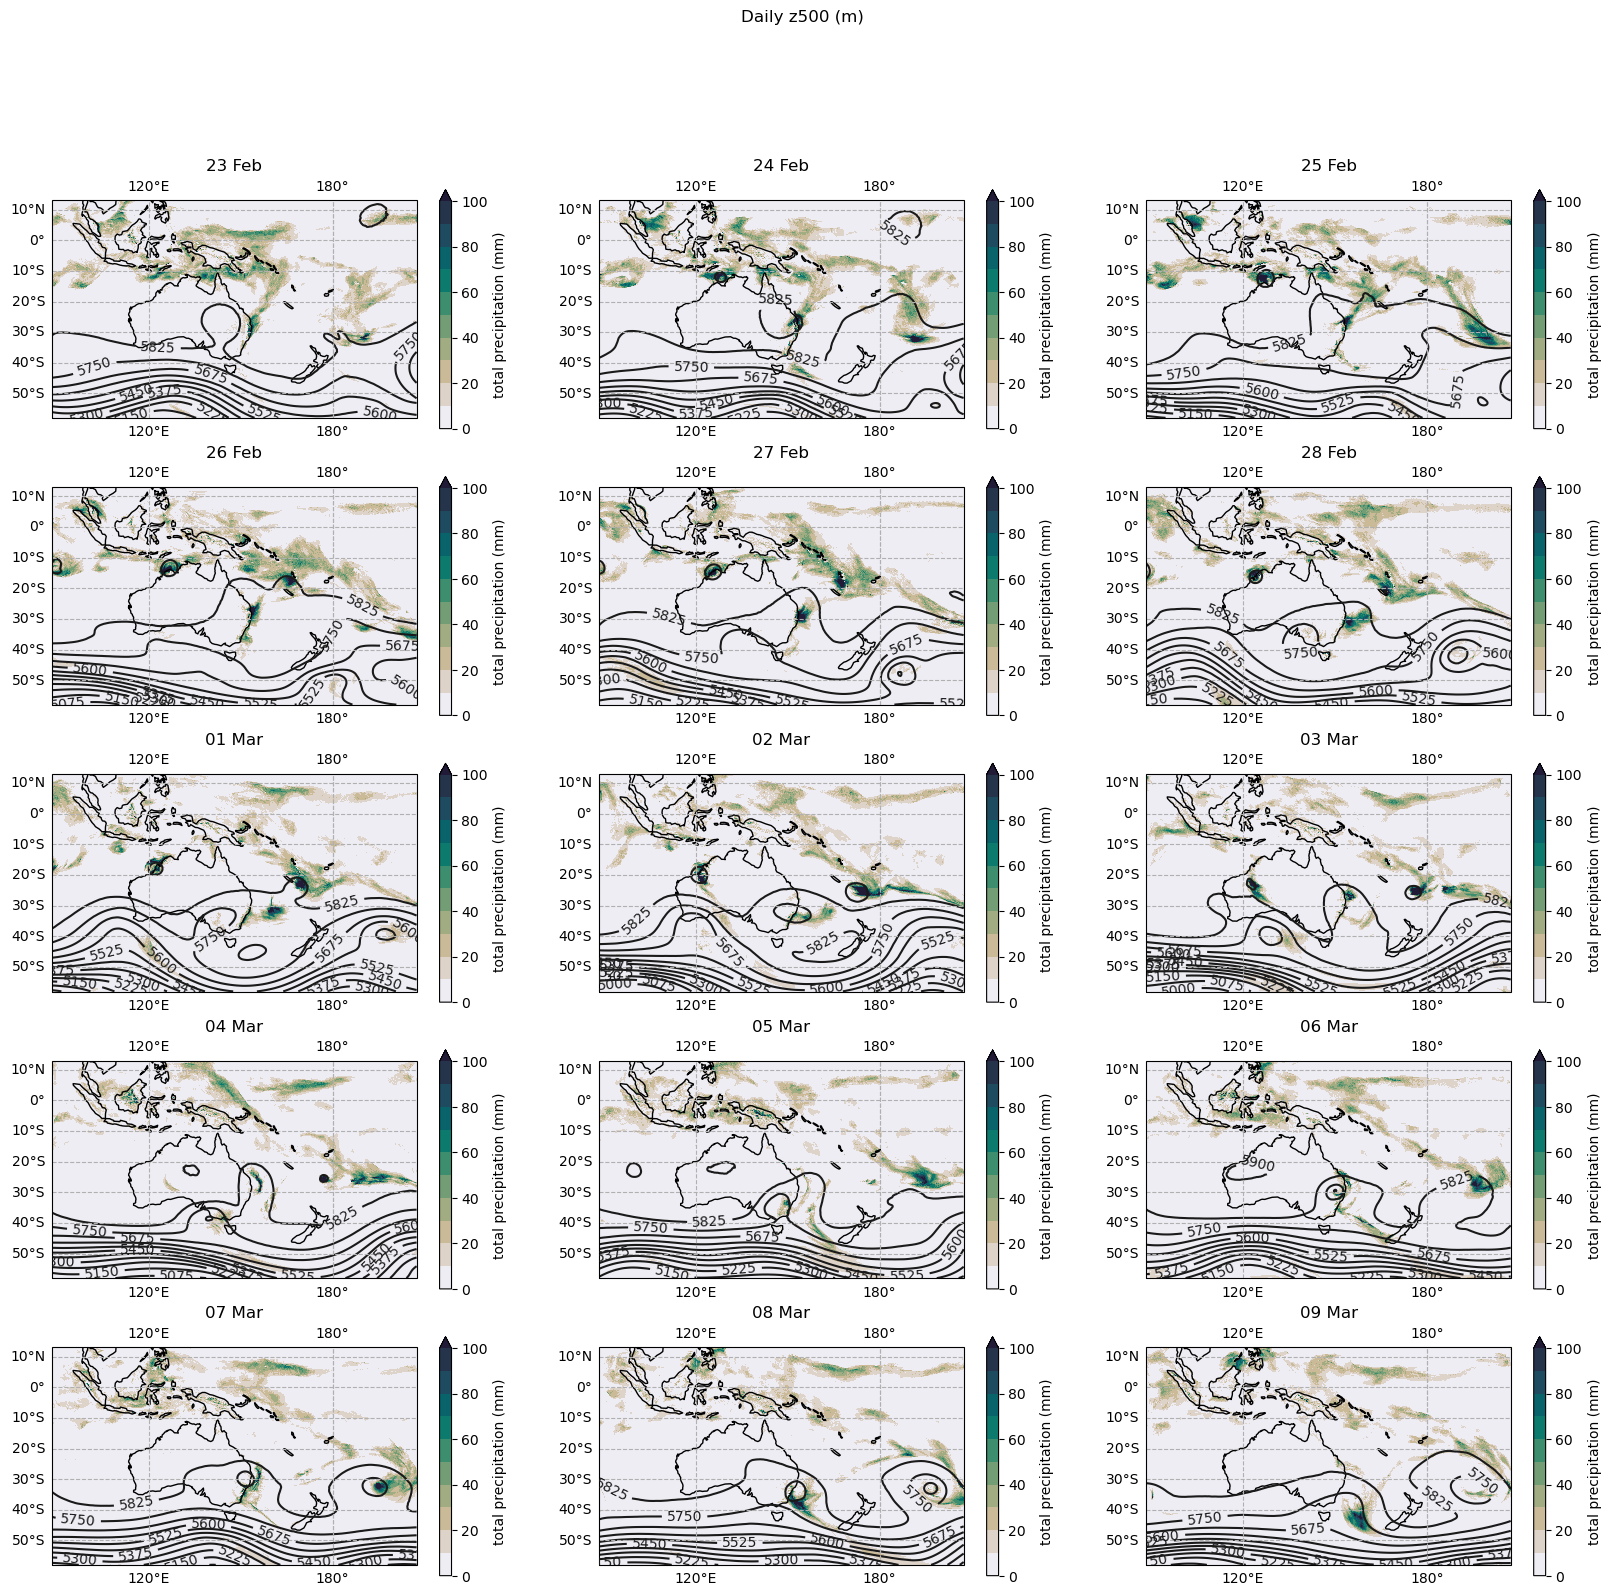

In [85]:
plot_days(z500_da, 'z500')

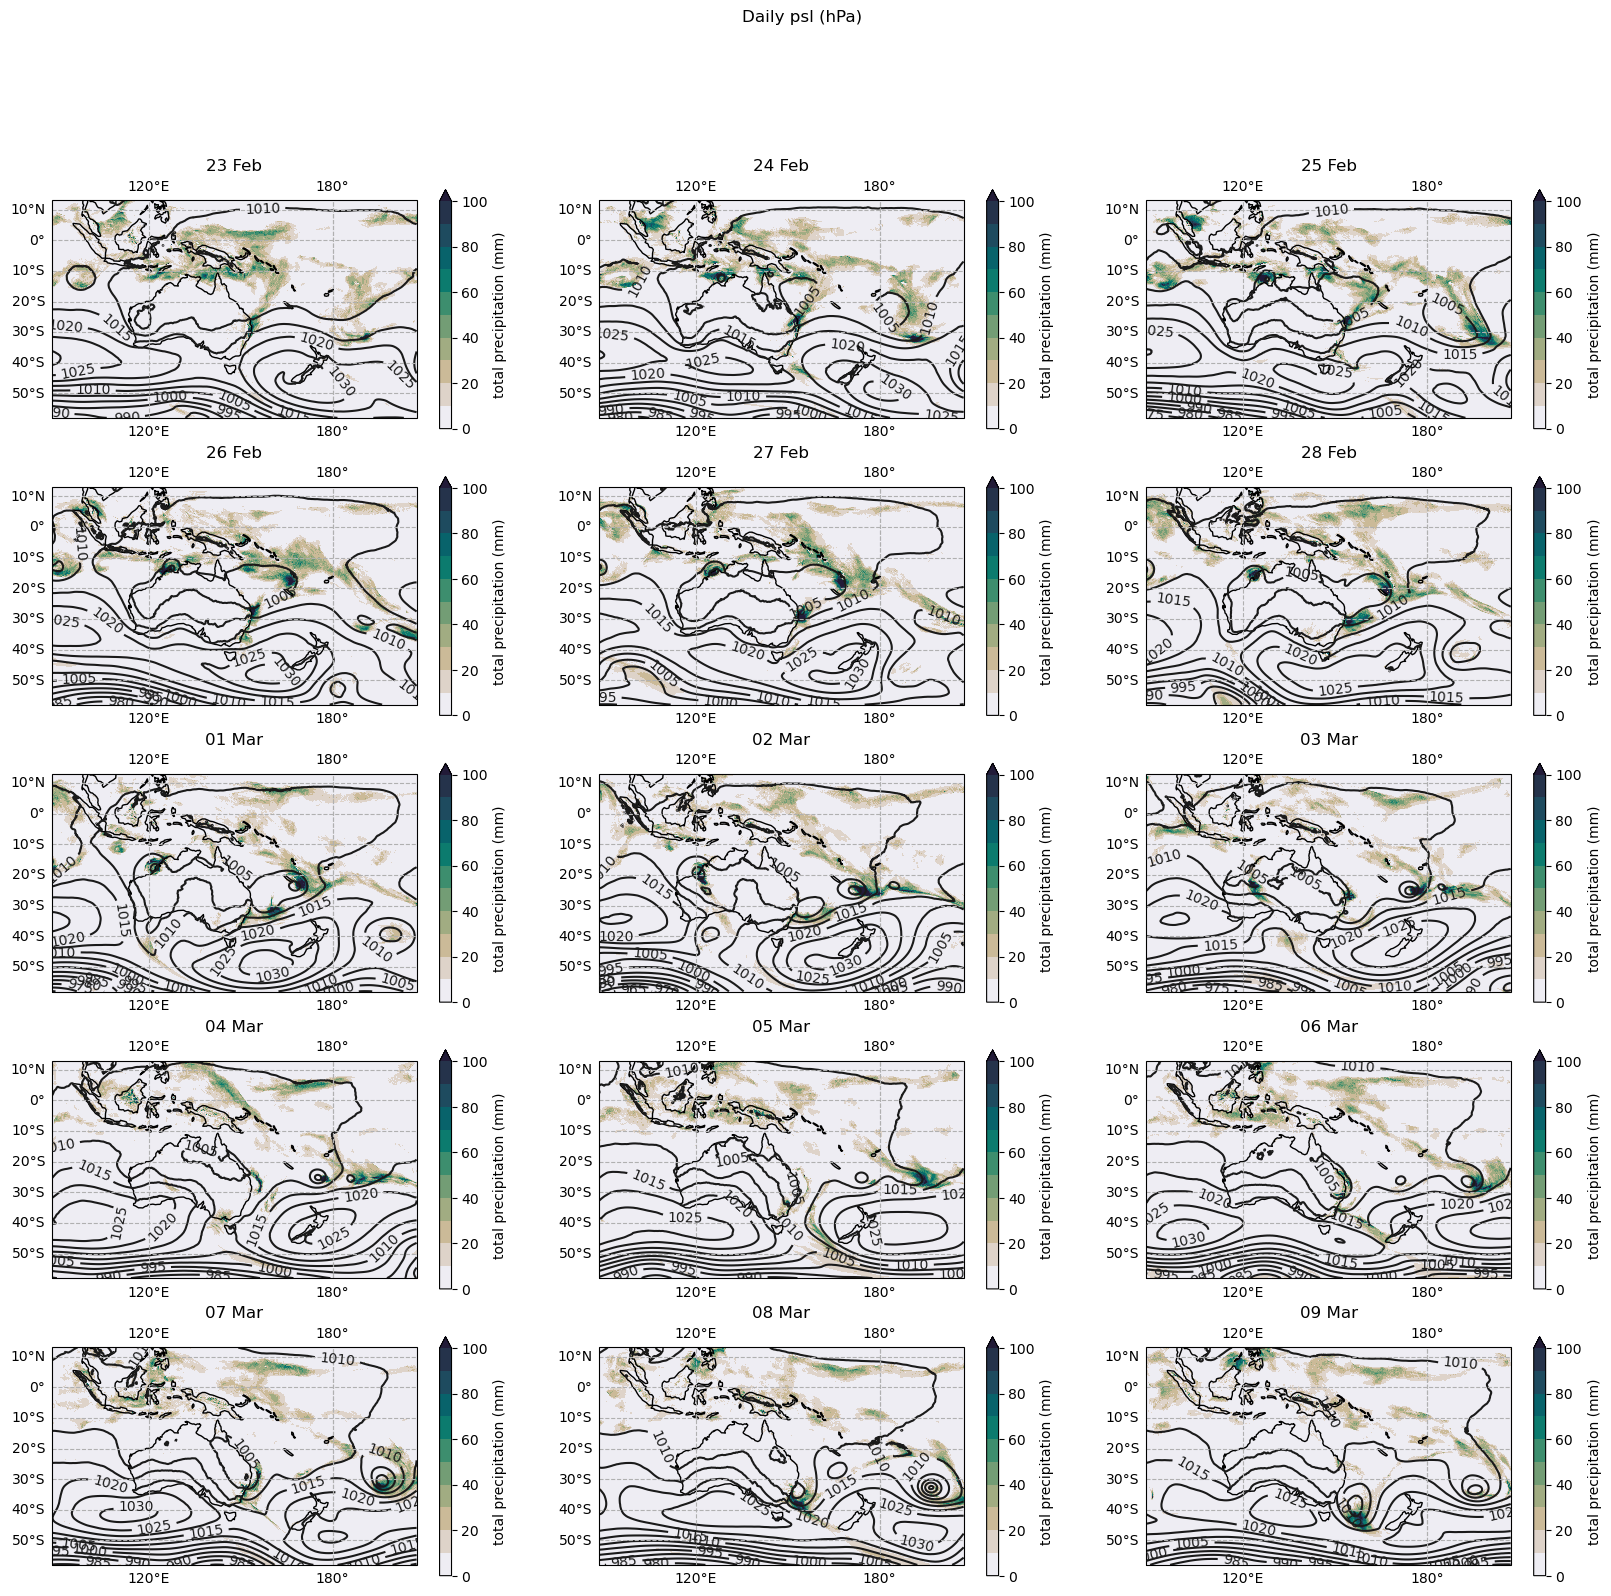

In [86]:
plot_days(psl_da, 'psl')